In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
%matplotlib inline
import os
import glob

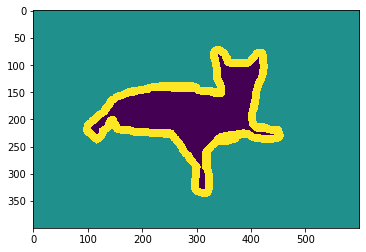

In [67]:
img = tf.io.read_file('./dataset/cls_location/annotations/trimaps/Abyssinian_1.png')
img = tf.image.decode_png(img)
img = tf.squeeze(img)
plt.imshow(img)

#### 获取所有的图片路径

In [68]:
images = glob.glob('./dataset/cls_location/images/*.jpg')
# 排序
images.sort(key=lambda x: os.path.splitext(os.path.split(x)[1])[0])

In [69]:
# 标注：annotation
anno = glob.glob('./dataset/cls_location/annotations/trimaps/*.png')
# 排序
anno.sort(key=lambda x: os.path.splitext(os.path.split(x)[1])[0])

In [70]:
np.random.seed(2020)
index = np.random.permutation(len(images))

In [71]:
# 进行乱序
images = np.array(images)[index]
anno = np.array(anno)[index]

In [72]:
# 创建dataset
dataset = tf.data.Dataset.from_tensor_slices((images, anno))

In [73]:
# 划分测试集和训练集
test_count = int(len(images)*0.2)
train_count = len(images) - test_count

ds_train = dataset.skip(test_count)
ds_test = dataset.take(test_count)

In [74]:
def read_jpg(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    return img

In [75]:
def read_png(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_png(img, channels=1)
    return img

In [76]:
def normal_img(input_img, input_anno):
    input_img = tf.cast(input_img, tf.float32)
    input_img = input_img/127.5 - 1
    input_anno -= 1
    return input_img, input_anno

In [77]:
def load_images(input_images_path, input_images_anno):
    input_images = read_jpg(input_images_path)
    input_anno = read_png(input_images_anno)
    input_images = tf.image.resize(input_images, [224, 224])
    input_anno = tf.image.resize(input_anno, [224, 224]) 
    return normal_img(input_images, input_anno )

In [78]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [79]:
ds_train = ds_train.map(load_images, num_parallel_calls=AUTOTUNE)
ds_test = ds_test.map(load_images, num_parallel_calls=AUTOTUNE)

In [80]:
BATCH_SIZE = 8

In [81]:
dataset_train = ds_train.shuffle(100).batch(BATCH_SIZE).repeat()
dataset_test = ds_test.batch(BATCH_SIZE)

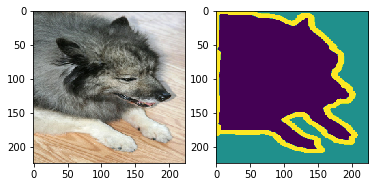

In [82]:
for img, anno in dataset_train.take(1):
    plt.subplot(1, 2, 1)
    plt.imshow(tf.keras.preprocessing.image.array_to_img(img[0]))
    plt.subplot(1, 2, 2)
    plt.imshow(tf.keras.preprocessing.image.array_to_img(anno[0]))

#### 定义model

In [19]:
covn_base = tf.keras.applications.VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

In [32]:
covn_base.get_layer('block5_conv3')

#### 获取中间层

In [21]:
layer_names = [
    'block5_conv3',
    'block4_conv3',
    'block3_conv3',
    'block5_pool'
]

In [22]:
layer_output = [covn_base.get_layer(name).output for name in layer_names]

In [23]:
# mulptout_model相当于继承了covn_base模型的权重
mulptout_model = tf.keras.models.Model(inputs=covn_base.input, outputs=layer_output)

In [27]:
mulptout_model.output

[<tf.Tensor 'block5_conv3/Identity:0' shape=(None, 14, 14, 512) dtype=float32>,
 <tf.Tensor 'block4_conv3/Identity:0' shape=(None, 28, 28, 512) dtype=float32>,
 <tf.Tensor 'block3_conv3/Identity:0' shape=(None, 56, 56, 256) dtype=float32>,
 <tf.Tensor 'block5_pool/Identity:0' shape=(None, 7, 7, 512) dtype=float32>]

In [24]:
mulptout_model.trainable = False

In [49]:
# 获取中间层的输出
inputs = tf.keras.layers.Input(shape=(224, 224, 3))
block5_conv3_out, block4_conv3_out, block3_conv3_out, out = mulptout_model(inputs=inputs)

In [50]:
# 进行反卷积(上采样)
x1 = tf.keras.layers.Conv2DTranspose(512, 3, strides=2, padding='same', activation='relu')(out)
x1 = tf.keras.layers.Conv2D(512, 3, activation='relu', padding='same')(x1)
x1 =  tf.add(x1, block5_conv3_out)
x1.shape

TensorShape([None, 14, 14, 512])

In [51]:
x2 = tf.keras.layers.Conv2DTranspose(512, 3, strides=2, padding='same', activation='relu')(x1)
x2 = tf.keras.layers.Conv2D(512, 3, activation='relu', padding='same')(x2)
x2 = tf.add(x2, block4_conv3_out)
x2.shape

TensorShape([None, 28, 28, 512])

In [52]:
x3 = tf.keras.layers.Conv2DTranspose(256, 3, strides=2, padding='same', activation='relu')(x2)
x3 = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same')(x3)
x3 = tf.add(x3, block3_conv3_out)
x3.shape

TensorShape([None, 56, 56, 256])

In [54]:
x4 = tf.keras.layers.Conv2DTranspose(128, 3, strides=2, padding='same', activation='relu')(x3)
x4 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(x4)
x4.shape

TensorShape([None, 112, 112, 128])

In [55]:
prediction = tf.keras.layers.Conv2DTranspose(3, 3, strides=2, padding='same', activation='softmax')(x4)

In [56]:
prediction.shape

TensorShape([None, 224, 224, 3])

In [57]:
model  = tf.keras.models.Model(inputs=inputs,  outputs=prediction)

In [59]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])

In [60]:
steps_per_epoch = train_count//BATCH_SIZE
validation_steps  = test_count//BATCH_SIZE

In [ ]:
model.fit(
    dataset_train,
    epochs=10,
    steps_per_epoch=steps_per_epoch,
    validation_data=dataset_test,
    validation_steps=validation_steps
)